1. Import Libraries

In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import save_image
import os
from tqdm import tqdm
import torch.optim as optim
import torchvision.io
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

2. Setup Environment and Directories

In [15]:
# Select GPU (cuda) if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the main project directory
project_root = "image_reconstruction_project"

# Create subdirectories for saving specific layer features and images
# exist_ok=True ensures we don't get an error if the folder already exists
os.makedirs("image_reconstruction_project/features/layer1", exist_ok=True)
os.makedirs("image_reconstruction_project/features/layer3", exist_ok=True)
os.makedirs("image_reconstruction_project/features/avgpool", exist_ok=True)
os.makedirs("image_reconstruction_project/images", exist_ok=True)

Set up the computation device to GPU for make computation faster and create the directory structure required to save the extracted features and images.

3. Data loading and Preprocessing

In [16]:
# Transform for the ResNet model
transform_norm = T.Compose([
    T.Resize(256),              # Resize smaller edge to 256
    T.CenterCrop(224),          # Center crop to 224x224
    T.ToTensor(),               # Convert PIL image to Tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], # Normalize
                std=[0.229, 0.224, 0.225])
])

# Transform for saving viewing images
transform_plain = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor()
])

print("Downloading Imagenette (ImageNet subset)")

# Dataset for feature extraction (Normalized)
dataset = torchvision.datasets.Imagenette(
    root='./data',
    split='train',
    size='320px',
    download=True,
    transform=transform_norm
)

# Dataset for saving images (Plain/Unnormalized)
dataset_plain = torchvision.datasets.Imagenette(
    root='./data',
    split='train',
    size='320px',
    download=True,
    transform=transform_plain
)

# Create DataLoaders to iterate through data in batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)
dataloader_plain = torch.utils.data.DataLoader(dataset_plain, batch_size=32, shuffle=False)

print(f"Dataset loaded! Classes: {len(dataset.classes)}")

Dataset loaded! Classes: 10


Image transformation was defined to normalize the data for Resnet - 101 to extract features and we load ImageNette dataset and create dataloaders. we also find that there are 10 distinct classes for the dataset.

4. Load Resnet - 101 for feature extraction

In [17]:
# Load the ResNet101 model with pre-trained ImageNet weights
model = models.resnet101(weights="IMAGENET1K_V2").to(device)

# Set model to evaluation mode (essential for inference/extraction)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Resnet - 101 is used for feature extraction. Evaluation mode is used to freeze layers like BatchNorm and dropout as we are not training the model using Resnet - 101, we are just extracting feature which will be passed through GAN architecture.

5. Extract and save features

In [18]:
# Dictionary to hold the output of the layers we hook into
features = {}

# Hook function: captures the output of a specific layer during the forward pass
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach() # Detach from gradients to save memory
    return hook

# Register hooks for the layers of interest
model.layer1.register_forward_hook(get_features('layer1'))
model.layer3.register_forward_hook(get_features('layer3'))
model.avgpool.register_forward_hook(get_features('avgpool'))

print("Extracting features and saving original images...")

save_limit = 1000  # Limit the number of samples to process (for demo purposes)
count = 0

# Iterator for plain images (to save the visual representation)
plain_iter = iter(dataloader_plain)

# Main extraction loop
for images, _ in tqdm(dataloader):
    try:
        # Get the corresponding batch of unnormalized images
        plain_images, _ = next(plain_iter)
    except StopIteration:
        break

    images = images.to(device)

    # Run the model (Forward pass) - hooks will capture features automatically
    with torch.no_grad():
        _ = model(images)

    # Retrieve features from the dictionary and move to CPU
    f1 = features['layer1'].cpu()
    f3 = features['layer3'].cpu()
    fpool = features['avgpool'].cpu()

    # Loop through the batch to save individual files
    for i in range(images.size(0)):
        img_id = count + i

        # Save the feature tensors (.pt files)
        torch.save(f1[i], f"image_reconstruction_project/features/layer1/{img_id:05d}.pt")
        torch.save(f3[i], f"image_reconstruction_project/features/layer3/{img_id:05d}.pt")
        torch.save(fpool[i], f"image_reconstruction_project/features/avgpool/{img_id:05d}.pt")

        # Save the original image (.png file)
        save_image(plain_images[i], f"image_reconstruction_project/images/{img_id:05d}.png")

    count += images.size(0)

    # Break loop if we reached the save limit
    if count >= save_limit:
        break

print(f"\nExtraction complete! Saved {count} samples.")

Extracting features and saving original images...


 10%|█         | 31/296 [06:08<52:30, 11.89s/it]


Extraction complete! Saved 1024 samples.


hooks is used to capture the output of specific layers (layer1, layer3, avgpool) as data passes through the model. We iterate through the dataset, run the images through the model, and save the captured feature tensors and the corresponding original images to the disk.

6. Verify extracted data

In [19]:
# Load one saved feature file to verify integrity
sample_f = torch.load("image_reconstruction_project/features/layer3/00000.pt")
print("Example feature shape (layer3):", sample_f.shape)

# Print location of corresponding image
print("Example image file saved at: image_reconstruction_project/images/00000.png")

Example feature shape (layer3): torch.Size([1024, 14, 14])
Example image file saved at: image_reconstruction_project/images/00000.png


A verification that its extracted, we load one saved feature file and print its shape.

7. Hyperparameters and directories

In [20]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 50

# Input: Layer 3 features | Target: Original Images
FEATURE_DIR = "image_reconstruction_project/features/layer3"
IMAGE_DIR = "image_reconstruction_project/images"

The batch size is 32 and epochs of 50 to train the GAN architecture.

8. Reconstruction Dataset

In [21]:
# Dataset class to match features with their target images
class FeatureDataset(Dataset):
    def __init__(self, feature_dir, image_dir):
        self.feature_dir = feature_dir
        self.image_dir = image_dir

        # Get list of all saved feature files
        all_features = sorted(os.listdir(feature_dir))

        # Filter: Keep only features that have a corresponding image file
        self.feature_files = []
        for feat_name in all_features:
            img_name = feat_name.replace('.pt', '.png')
            img_path = os.path.join(self.image_dir, img_name)

            if os.path.exists(img_path):
                self.feature_files.append(feat_name)

        print(f"Found {len(self.feature_files)} valid pairs.")

        # Transform target image to [-1, 1] range (standard for GANs)
        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.feature_files)

    def __getitem__(self, idx):
        # 1. Load Input (Feature)
        feat_name = self.feature_files[idx]
        feat_path = os.path.join(self.feature_dir, feat_name)
        feature = torch.load(feat_path) # Shape: [1024, 14, 14]

        # 2. Load Target (Image)
        img_name = feat_name.replace('.pt', '.png')
        img_path = os.path.join(self.image_dir, img_name)

        image = torchvision.io.read_image(img_path)
        image = T.ToPILImage()(image)
        image = self.transform(image)

        return feature, image

# Create DataLoader
dataset_recon = FeatureDataset(FEATURE_DIR, IMAGE_DIR)
dataloader_recon = DataLoader(dataset_recon, batch_size=BATCH_SIZE, shuffle=True)

Found 1024 valid pairs.


It pairs the saved feature tensors (.pt) with their corresponding images (.png). The images are resized and normalized to the range [-1, 1], which is standard for GANs using Tanh activation.

9. GAN Model

In [22]:
# Generator: Upsamples feature maps to RGB images
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Starting from 1024 channels (Layer 3 output)
        self.model = nn.Sequential(
            # Upsample 1: 14 -> 28
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # Upsample 2: 28 -> 56
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # Upsample 3: 56 -> 112
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample 4: 112 -> 224
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Output: 224x224 RGB Image
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh() # Output range [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# Discriminator: Distinguishes between real and reconstructed images
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Conv block helper
        def block(in_f, out_f, bn=True):
            layers = [nn.Conv2d(in_f, out_f, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True)]
            if bn: layers.append(nn.BatchNorm2d(out_f))
            return layers

        self.model = nn.Sequential(
            *block(3, 64, bn=False), # 224 -> 112
            *block(64, 128),         # 112 -> 56
            *block(128, 256),        # 56 -> 28
            *block(256, 512),        # 28 -> 14
            *block(512, 1024),       # 14 -> 7
        )

        # Classification layer
        self.adv_layer = nn.Conv2d(1024, 1, 7, 1, 0)

    def forward(self, img):
        out = self.model(img)
        out = self.adv_layer(out)
        return torch.sigmoid(out).view(out.size(0), -1)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions
criterion_gan = nn.BCELoss()    # Adversarial loss
criterion_pixel = nn.L1Loss()   # Pixel reconstruction loss

# Optimizers
opt_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))

Generator takes the feature map (14x14) and uses Transposed Convolutions to upsample it back to an image (224x224).

Discriminator is a standard classifier that takes an image and outputs a probability of it being "real" vs "fake".

We also define the two loss functions which are binary Cross Entropy for adversarial loss and L1 for pixel-wise similarity and optimizers  as Adam.

10. Training of the GAN model

Starting Training
[Epoch 1/50] [Acc: 0.6982] [D Loss: 2.5203] [G Loss: 4.2581]
[Epoch 2/50] [Acc: 0.6406] [D Loss: 1.0833] [G Loss: 2.5017]
[Epoch 3/50] [Acc: 0.6509] [D Loss: 1.0080] [G Loss: 2.2208]
[Epoch 4/50] [Acc: 0.6392] [D Loss: 1.1810] [G Loss: 2.1430]
[Epoch 5/50] [Acc: 0.6533] [D Loss: 0.9585] [G Loss: 2.1099]


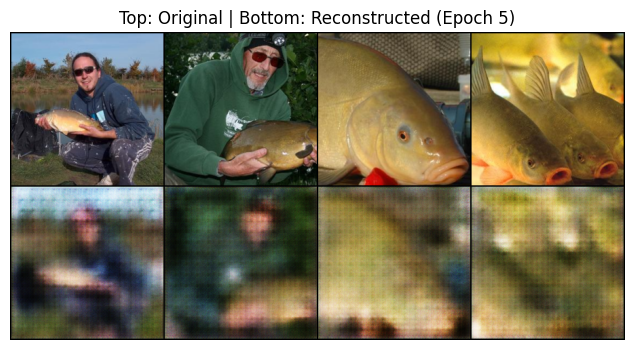

[Epoch 6/50] [Acc: 0.6641] [D Loss: 1.0729] [G Loss: 2.1106]
[Epoch 7/50] [Acc: 0.6802] [D Loss: 0.9376] [G Loss: 2.0800]
[Epoch 8/50] [Acc: 0.6909] [D Loss: 0.9441] [G Loss: 2.0882]
[Epoch 9/50] [Acc: 0.6963] [D Loss: 0.8752] [G Loss: 2.0784]
[Epoch 10/50] [Acc: 0.7266] [D Loss: 0.9838] [G Loss: 2.0544]


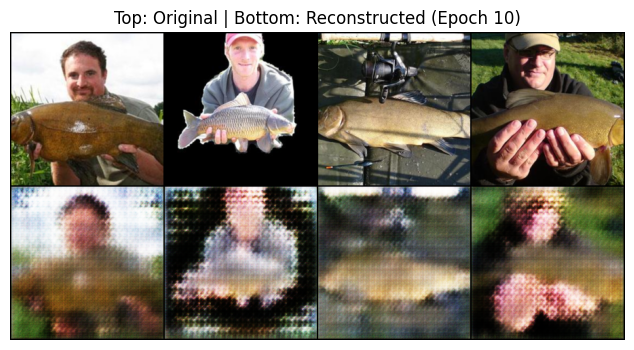

[Epoch 11/50] [Acc: 0.6826] [D Loss: 1.0084] [G Loss: 2.0679]
[Epoch 12/50] [Acc: 0.7134] [D Loss: 0.8862] [G Loss: 2.0604]
[Epoch 13/50] [Acc: 0.6899] [D Loss: 0.9259] [G Loss: 2.0319]
[Epoch 14/50] [Acc: 0.7070] [D Loss: 0.9758] [G Loss: 2.0258]
[Epoch 15/50] [Acc: 0.7012] [D Loss: 1.3678] [G Loss: 1.9898]


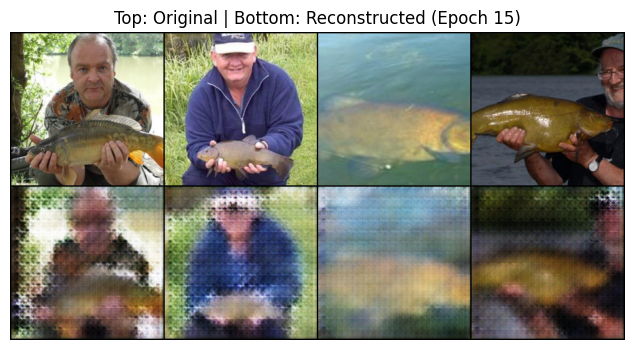

[Epoch 16/50] [Acc: 0.7080] [D Loss: 0.8665] [G Loss: 2.0294]
[Epoch 17/50] [Acc: 0.7212] [D Loss: 0.9354] [G Loss: 1.9705]
[Epoch 18/50] [Acc: 0.7051] [D Loss: 1.0220] [G Loss: 1.9976]
[Epoch 19/50] [Acc: 0.6929] [D Loss: 0.9501] [G Loss: 1.9781]
[Epoch 20/50] [Acc: 0.7139] [D Loss: 1.0352] [G Loss: 1.9889]


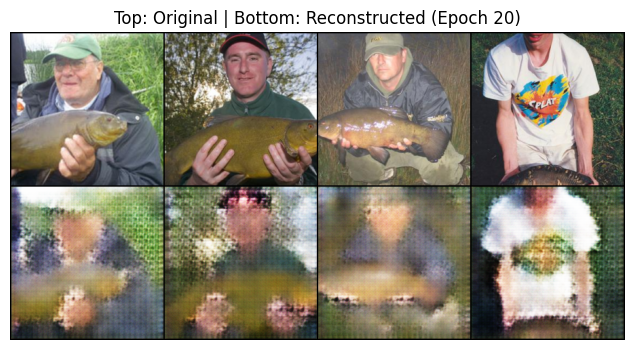

[Epoch 21/50] [Acc: 0.7095] [D Loss: 1.2980] [G Loss: 1.9673]
[Epoch 22/50] [Acc: 0.7471] [D Loss: 1.2197] [G Loss: 1.9561]
[Epoch 23/50] [Acc: 0.7305] [D Loss: 1.0353] [G Loss: 1.9760]
[Epoch 24/50] [Acc: 0.7310] [D Loss: 0.9652] [G Loss: 1.8996]
[Epoch 25/50] [Acc: 0.7314] [D Loss: 0.8284] [G Loss: 1.9328]


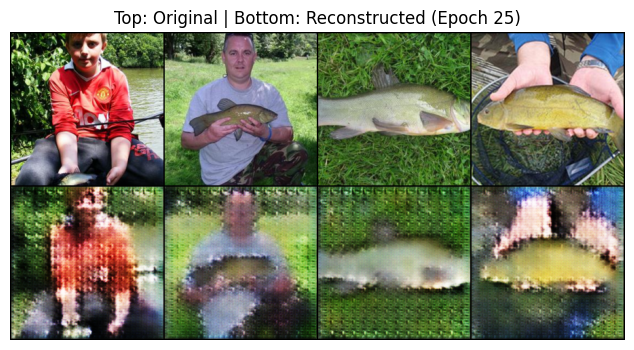

[Epoch 26/50] [Acc: 0.7319] [D Loss: 0.8686] [G Loss: 1.9699]
[Epoch 27/50] [Acc: 0.7354] [D Loss: 0.8476] [G Loss: 1.8900]
[Epoch 28/50] [Acc: 0.7451] [D Loss: 0.8750] [G Loss: 1.9379]
[Epoch 29/50] [Acc: 0.7261] [D Loss: 0.8968] [G Loss: 1.9118]
[Epoch 30/50] [Acc: 0.7510] [D Loss: 0.7556] [G Loss: 1.9621]


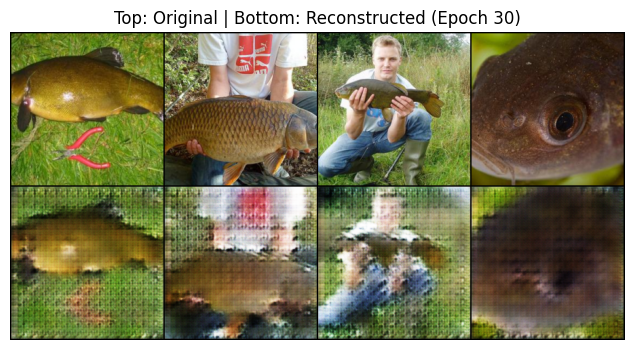

[Epoch 31/50] [Acc: 0.7539] [D Loss: 0.7198] [G Loss: 1.9354]
[Epoch 32/50] [Acc: 0.7642] [D Loss: 0.7365] [G Loss: 1.9096]
[Epoch 33/50] [Acc: 0.7529] [D Loss: 0.7408] [G Loss: 1.8780]
[Epoch 34/50] [Acc: 0.7534] [D Loss: 0.7081] [G Loss: 1.8868]
[Epoch 35/50] [Acc: 0.7549] [D Loss: 0.6713] [G Loss: 1.9070]


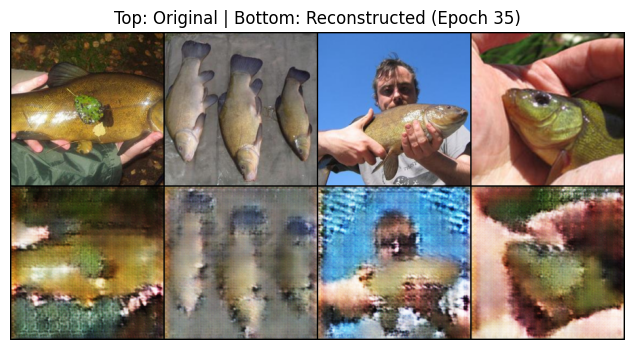

[Epoch 36/50] [Acc: 0.7476] [D Loss: 0.7826] [G Loss: 1.8612]
[Epoch 37/50] [Acc: 0.7739] [D Loss: 0.6045] [G Loss: 1.8825]
[Epoch 38/50] [Acc: 0.7891] [D Loss: 0.6160] [G Loss: 1.8694]
[Epoch 39/50] [Acc: 0.7734] [D Loss: 0.6047] [G Loss: 1.8344]
[Epoch 40/50] [Acc: 0.7734] [D Loss: 0.6514] [G Loss: 1.8432]


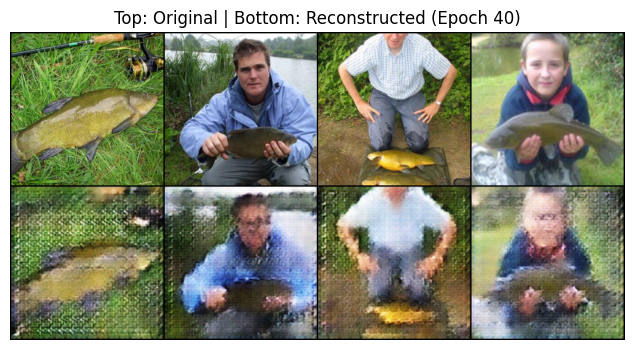

[Epoch 41/50] [Acc: 0.7749] [D Loss: 0.6599] [G Loss: 1.9003]
[Epoch 42/50] [Acc: 0.7573] [D Loss: 0.7088] [G Loss: 1.8414]
[Epoch 43/50] [Acc: 0.7681] [D Loss: 0.7182] [G Loss: 1.8466]
[Epoch 44/50] [Acc: 0.7812] [D Loss: 0.6052] [G Loss: 1.8296]
[Epoch 45/50] [Acc: 0.8042] [D Loss: 0.5903] [G Loss: 1.7928]


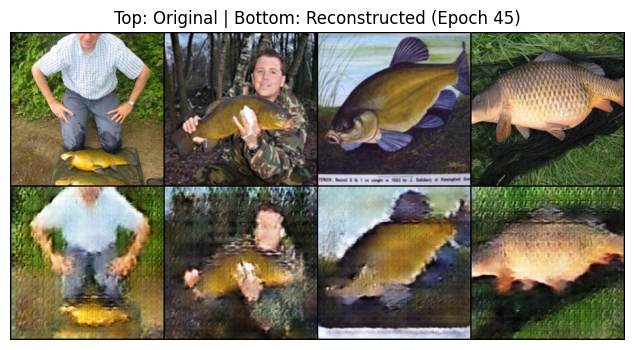

[Epoch 46/50] [Acc: 0.7812] [D Loss: 0.6553] [G Loss: 1.8207]
[Epoch 47/50] [Acc: 0.8203] [D Loss: 0.5010] [G Loss: 1.7733]
[Epoch 48/50] [Acc: 0.8022] [D Loss: 0.5721] [G Loss: 1.8201]
[Epoch 49/50] [Acc: 0.7905] [D Loss: 0.6261] [G Loss: 1.7750]
[Epoch 50/50] [Acc: 0.8086] [D Loss: 0.5514] [G Loss: 1.7889]


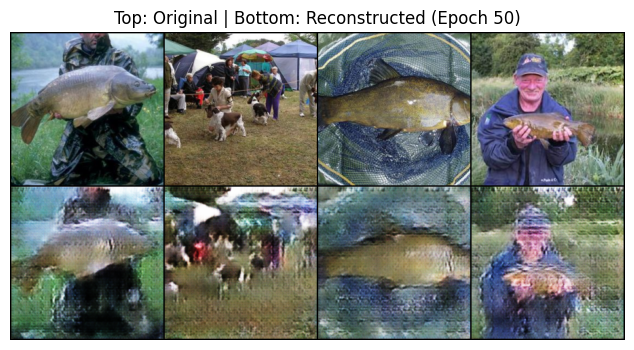

In [23]:
import numpy as np

# Lists to track metrics for plotting
history_d_loss = []
history_g_loss = []
history_acc = []

print("Starting Training")

for epoch in range(EPOCHS):

    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    epoch_acc = 0.0

    for i, (features, real_imgs) in enumerate(dataloader_recon):

        features = features.to(device)
        real_imgs = real_imgs.to(device)
        batch_size = features.size(0)

        # 1. Label Smoothing: This prevents the discriminator from becoming too confident (overfitting)
        valid = torch.ones(batch_size, 1).to(device) * 0.9

        # Fake labels
        fake = torch.zeros(batch_size, 1).to(device)

        # 2. Add Noise to Discriminator Inputs
        noise_strength = 0.1
        real_imgs_noisy = real_imgs + (torch.randn_like(real_imgs) * noise_strength)

        #  Train Generator
        opt_g.zero_grad()

        gen_imgs = generator(features)

        # Generator wants Discriminator to think images are Real
        pred_fake_g = discriminator(gen_imgs)
        loss_gan = criterion_gan(pred_fake_g, torch.ones(batch_size, 1).to(device)) # Try to hit 1.0

        loss_pixel = criterion_pixel(gen_imgs, real_imgs)

        g_loss = 0.05 * loss_gan + 10 * loss_pixel

        g_loss.backward()
        opt_g.step()

        #  Train Discriminator
        opt_d.zero_grad()

        # Train on Real
        pred_real = discriminator(real_imgs_noisy)
        loss_real = criterion_gan(pred_real, valid)

        # Train on Fake
        gen_imgs_noisy = gen_imgs.detach() + (torch.randn_like(gen_imgs) * noise_strength)
        pred_fake_d = discriminator(gen_imgs_noisy)
        loss_fake = criterion_gan(pred_fake_d, fake)

        d_loss = 0.5 * (loss_real + loss_fake)

        d_loss.backward()
        opt_d.step()

        #  Calculate Accuracy
        with torch.no_grad():
            # Real is correct if > 0.5
            acc_real = (pred_real > 0.5).float().mean()
            # Fake is correct if < 0.5
            acc_fake = (pred_fake_d < 0.5).float().mean()
            batch_acc = (acc_real + acc_fake) / 2

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_acc += batch_acc.item()

    # Average metrics
    avg_d_loss = epoch_d_loss / len(dataloader_recon)
    avg_g_loss = epoch_g_loss / len(dataloader_recon)
    avg_acc = epoch_acc / len(dataloader_recon)

    history_d_loss.append(avg_d_loss)
    history_g_loss.append(avg_g_loss)
    history_acc.append(avg_acc)

    print(f"[Epoch {epoch+1}/{EPOCHS}] [Acc: {avg_acc:.4f}] [D Loss: {avg_d_loss:.4f}] [G Loss: {avg_g_loss:.4f}]")

    # Visualization
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            # Combine real and generated images for comparison
            display_imgs = torch.cat((real_imgs[:4], gen_imgs[:4]), 0)
            display_imgs = (display_imgs * 0.5) + 0.5 # Denormalize

            grid = make_grid(display_imgs, nrow=4)
            plt.figure(figsize=(8, 4))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.title(f"Top: Original | Bottom: Reconstructed (Epoch {epoch+1})")
            plt.show()

Generator Step tries to generate an image from the feature vector. It is trained to minimize two losses, loss_gan which tries to trick the discriminator into thinking the image is real and loss_pixel which tries to make the generated image look exactly like the original input image (L1 distance).

Discriminator Step: It tries to correctly classify real images as 1 and generated fake images as 0.

Visualization: Every 5 epochs, it displays a batch of Real vs. Reconstructed images to monitor progress.

11. Plot Loss and Accuracy

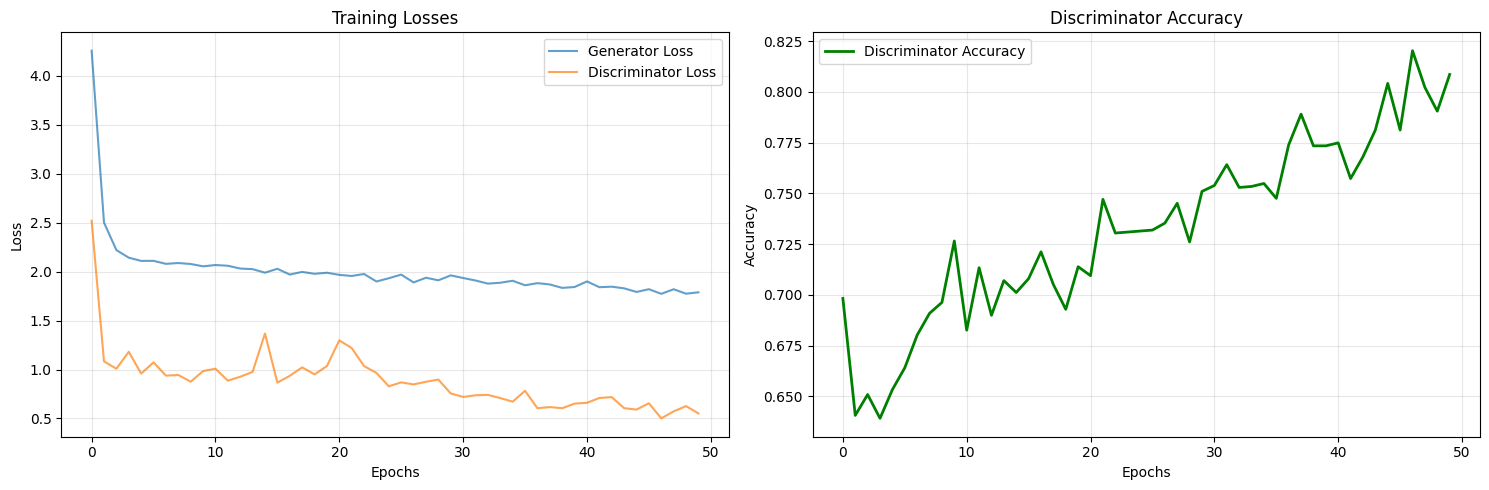

In [24]:
plt.figure(figsize=(15, 5))

# Plot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(history_g_loss, label='Generator Loss', alpha=0.7)
plt.plot(history_d_loss, label='Discriminator Loss', alpha=0.7)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_acc, label='Discriminator Accuracy', color='green', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()